# Определение стоимости автомобилей

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-проекта" data-toc-modified-id="Описание-проекта-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание проекта</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Изучение-и-предобработка-данных" data-toc-modified-id="Изучение-и-предобработка-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Изучение и предобработка данных</a></span></li><li><span><a href="#Подготовка-выборок-для-обучения моделей" data-toc-modified-id="Подготовка-выборок-для-обучения-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Подготовка выборок для обучения моделей</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Анализ-работы-моделей" data-toc-modified-id="Анализ-работы-моделей-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Анализ работы моделей</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div></ul></div>

## Описание проекта

**Заказчик:** Сервис по продаже автомобилей с пробегом «Не бит, не крашен», разрабатывающее приложение для привлечения новых клиентов. 

**Задача:** быстро узнать рыночную стоимость автомобиля по историческим данным: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости.   

Важные моменты для Заказчика:  
* качество предсказания;
* скорость предсказания модели;
* время обучения модели.  

### Описание данных  

Данные находятся в файле `/datasets/autos.csv`. 

**Признаки:**
* *DateCrawled* — дата скачивания анкеты из базы
* *VehicleType* — тип автомобильного кузова
* *RegistrationYear* — год регистрации автомобиля
* *Gearbox* — тип коробки передач
* *Power* — мощность (л. с.)
* *Model* — модель автомобиля
* *Kilometer* — пробег (км)
* *RegistrationMonth* — месяц регистрации автомобиля
* *FuelType* — тип топлива
* *Brand* — марка автомобиля
* *Repaired* — была машина в ремонте или нет
* *DateCreated* — дата создания анкеты
* *NumberOfPictures* — количество фотографий автомобиля
* *PostalCode* — почтовый индекс владельца анкеты (пользователя)
* *LastSeen* — дата последней активности пользователя  

**Целевой признак:**
* *Price* — цена (евро)

### Ход выполнения проекта

Проект будем выполнять в несколько этапов:
1. Загрузим данные.
2. Изучим данные. Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков будут неинформативные, удалим их.
3. Подготовим выборки для обучения моделей.
4. Обучим разные модели. Для каждой модели попробуем разные гиперпараметры.
5. Проанализирем время обучения, время предсказания и качество моделей.
6. Опираясь на критерии Заказчика, выберем лучшую модель, проверим её качество на тестовой выборке.

Примечания:  
* Для оценки качества моделей применим метрику *RMSE*.
* Значение метрики RMSE по требованию Заказчика должно быть меньше 2500.
* Построим модели градиентного бустинга средствами библиотеки `LightGBM`.
* Поскольку модель градиентного бустинга может обучаться долго, изменять у неё будем только два-три параметра.

## Загрузка данных

In [1]:
! pip install -q phik

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import phik
from phik.report import plot_correlation_matrix

from scipy import stats as st

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import (
    OrdinalEncoder,
    OneHotEncoder
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split
)  
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import warnings

In [3]:
# увеличим максимальное количество отображаемых столбцов
pd.set_option('display.max_columns', None)

# Вывести из под комментария перед финальным запуском:
# Игнорируем предупреждения о возможных изменениях работы функций в будущих версиях в Pandas
warnings.filterwarnings("ignore") 

In [4]:
# считывание csv-файла
try: 
    main_df = pd.read_csv('/datasets/autos.csv')
except:
    main_df = pd.read_csv('autos.csv')

Зададим значение `random_state`, которое будет использоваться на протяжении всего проекта. 

In [5]:
RANDOM_STATE = 12345

Создадим копию датафрейма, чтобы убедиться, что данные не испорчены после предобработки.

In [6]:
df = main_df.copy(deep=True)

## Изучение и предобработка данных

### Изучение данных

Для изучения общей информации о датафрейме напишем функцию:

In [7]:
def description_df(df):
    '''
    Выводит первые 5 строк датафрейма, общую информацию о датафрейме,
    показывает описание количественных признаков, проверяет наличие дубликатов
    '''
    
    # Выведем общую информацию о таблице
    display(df.head())
    df.info()
    display(df.describe())
    
    # Проверим наличие дубликатов
    if df.duplicated().sum() == 0:
        print('Дубликатов не обнаружено')
    else:
        print('Количество полных дубликатов:', df.duplicated().sum())

In [8]:
description_df(df)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Количество полных дубликатов: 4


Сразу видим, что в данных довольно много пропусков. Выведем количество пропущенных данных по каждому столбцу в процентах:

In [9]:
(df.isna().mean() * 100).round(2)

DateCrawled           0.00
Price                 0.00
VehicleType          10.58
RegistrationYear      0.00
Gearbox               5.60
Power                 0.00
Model                 5.56
Kilometer             0.00
RegistrationMonth     0.00
FuelType              9.28
Brand                 0.00
Repaired             20.08
DateCreated           0.00
NumberOfPictures      0.00
PostalCode            0.00
LastSeen              0.00
dtype: float64

**Вывод:**  
* Некоторые столбцы не несут в себе полезной для обучения моделей информации, их потребуется удалить;
* Названия столбцов датафрейма не соответствуют "хорошему стилю" - необходимо будет переименовать столбцы;
* В данных имеются полные дубликаты, их также необходимо будет удалить. После этого проведем проверку на неявные дубликаты;
* По значениям количественных признаков наблюдается присутствие аномальных значений. Необходимо проверить распределения признаков и устранить выбросы;
* Также присутствует довольно много пропусков. Возможно некоторые из них устранятся после устранения выбросов.

### Предобработка данных

In [10]:
# Выведем названия всех столбцов
list(df)

['DateCrawled',
 'Price',
 'VehicleType',
 'RegistrationYear',
 'Gearbox',
 'Power',
 'Model',
 'Kilometer',
 'RegistrationMonth',
 'FuelType',
 'Brand',
 'Repaired',
 'DateCreated',
 'NumberOfPictures',
 'PostalCode',
 'LastSeen']

Приведем названия столбцов в соответствие "хорошему стилю"

In [11]:
df = df.rename(columns={'DateCrawled': 'date_crawled',
                        'Price': 'price',
                        'VehicleType': 'vehicle_type',
                        'RegistrationYear': 'registration_year',
                        'Gearbox': 'gearbox',
                        'Power': 'power',
                        'Model': 'model',
                        'Kilometer': 'kilometer',
                        'RegistrationMonth': 'registration_month',
                        'FuelType': 'fuel_type',
                        'Brand': 'brand',
                        'Repaired': 'repaired',
                        'DateCreated': 'date_created',
                        'NumberOfPictures': 'number_of_pictures',
                        'PostalCode': 'postal_code',
                        'LastSeen': 'last_seen'})
list(df)

['date_crawled',
 'price',
 'vehicle_type',
 'registration_year',
 'gearbox',
 'power',
 'model',
 'kilometer',
 'registration_month',
 'fuel_type',
 'brand',
 'repaired',
 'date_created',
 'number_of_pictures',
 'postal_code',
 'last_seen']

Проверим неявные дубликаты в столбцах `vehicle_type`, `gearbox`, `model`, `fuel_type`, `brand` и `repaired`. Для этого выведем все уникальные значения данных столбцов:

In [12]:
# Создадим датафрейм с указанными столбцами
df_unique = df[['vehicle_type',
               'gearbox',
               'model',
               'fuel_type',
               'brand',
               'repaired']]
# Выведем уникальные значения каждого столбца
for column in df_unique.columns:
    print(column, '\n', df[column].unique(), '\n') 

vehicle_type 
 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

gearbox 
 ['manual' 'auto' nan] 

model 
 ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er' 'modus' 'fox' 'matiz' 'beetle' 'c1' 'rio' 'touareg'
 'logan' 'spid

В столбце `brand` пропуски отсутствуют.  

В столбцах `vehicle_type`, `gearbox`, `model` и `fuel_type` заменим `nan` на категориальную моду (наиболее часто встречающуюся категорию) в зависимости от определенных групп столбцов. Для этого создадим отдельный класс заполнения пропусков:

In [13]:
class FillNan:
    def data_object(self, column_fill, column_group_1, column_group_2, data=df):
        '''
        функция заполнения пропусков для типа данных object
        '''
        data[column_fill] = data.groupby([column_group_1, column_group_2])[column_fill].transform(
                                    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'unknown'))
        
    def data_num(self, column_fill, column_group_1, column_group_2, data=df):
        '''
        функция заполнения пропусков для типа данных numerical
        '''
        data[column_fill] = data.groupby([column_group_1, column_group_2])[column_fill].transform(
                                    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

In [14]:
fill_nan = FillNan()

Пропуски моделей заполним в зависимости от бренда и количества лошадиных сил.   

Пропуски для типа кузова, коробки передач и типа топлива заполним в зависимости от бренда и модели авто.   

Во всех случаях если какие-либо значения будут отсутствовать - проставим значение `unknown`.

In [15]:
fill_nan.data_object('model', 'brand', 'power')

In [16]:
fill_nan.data_object('vehicle_type', 'brand', 'model')

In [17]:
fill_nan.data_object('gearbox', 'brand', 'model')

In [18]:
fill_nan.data_object('fuel_type', 'brand', 'model')

На счет заполнения столбца `repaired` нельзя однозначно сказать можно ли в нем заполнить пропуски `nan` на `yes` или `no`, т.к. в зависимости от того или иного ответа стоимость автомобиля может быть различной. Посчитаем среднюю стоимость автомобилей для каждого значения:

In [19]:
print('Средняя цена ремонтированного авто:', df[df['repaired'] == 'yes']['price'].mean().round(2))
print('Средняя цена не ремонтированного авто:', df[df['repaired'] == 'no']['price'].mean().round(2))
print('Средняя цена неизвестно ремонтированного ли авто:', df[(df['repaired'] != 'yes') & (df['repaired'] != 'no')]['price'].mean().round(2))

Средняя цена ремонтированного авто: 1916.04
Средняя цена не ремонтированного авто: 5296.81
Средняя цена неизвестно ремонтированного ли авто: 2626.42


На первый вгляд сразу видно, что все стоимости различны. Сформилируем и проверим эту гипотезу для ремонтированных авто:
* Основная гипотеза **H₀**: средняя цена ремонтированных автомобилей (`repaired` = `yes`) и неизвестно ремонтированных ли автомобилей (`repaired` = `nan`) одинакова.
* Альтернативная гипотеза **H₁**: средняя цена ремонтированных автомобилей (`repaired` = `yes`) и неизвестно ремонтированных ли автомобилей (`repaired` = `nan`) различна.

In [20]:
# Обозначим уровень значимости
alpha = 0.05

# Проверим гипотезу о равенстве двух средних
results =  st.ttest_ind(df[df['repaired'] == 'yes']['price'], 
                        df[(df['repaired'] != 'yes') & (df['repaired'] != 'no')]['price'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 6.76283705089867e-266
Отвергаем нулевую гипотезу


Аналогично сформулируем и проверим гипотезу для не ремонтированных авто:
* Основная гипотеза **H₀**: средняя цена не ремонтированных автомобилей (`repaired` = `no`) и неизвестно ремонтированных ли автомобилей (`repaired` = `nan`) одинакова.
* Альтернативная гипотеза **H₁**: средняя цена не ремонтированных автомобилей (`repaired` = `no`) и неизвестно ремонтированных ли автомобилей (`repaired` = `nan`) различна.

In [21]:
# Обозначим уровень значимости
alpha = 0.05

# Проверим гипотезу о равенстве двух средних
results =  st.ttest_ind(df[df['repaired'] == 'no']['price'], 
                        df[(df['repaired'] != 'yes') & (df['repaired'] != 'no')]['price'])

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0
Отвергаем нулевую гипотезу


Отвергли обе нулевые гипотезы, поэтому предлагается заменить все пропуски данного столбца значением `unknown`.

In [22]:
df['repaired'] = np.where(((df['repaired'] != 'yes') & (df['repaired'] != 'no')),
                         'unknown',
                         df.repaired)

Еще раз выведем процент имеющихся пропусков в датафрейме

In [23]:
(df.isna().mean() * 100).round(6)

date_crawled          0.0
price                 0.0
vehicle_type          0.0
registration_year     0.0
gearbox               0.0
power                 0.0
model                 0.0
kilometer             0.0
registration_month    0.0
fuel_type             0.0
brand                 0.0
repaired              0.0
date_created          0.0
number_of_pictures    0.0
postal_code           0.0
last_seen             0.0
dtype: float64

От пропусков избавились, перейдем к анализу распределений и выбросов.

Напишем функция для построения распределений:

In [24]:
def hist_df(df, name):
    '''
    строит гистограмму
    '''
    plt.figure(figsize=(15,5))
    plt.grid(True)
    ax = sns.distplot(df, bins=100)
    plt.title(name, fontsize=20)

Изучим данные, когда были скачаны анкеты из базы.

In [25]:
# Преобразуем столбец в формат даты
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%Y-%m-%d %H:%M:%S')
df['date_crawled'].sample(5)

264686   2016-03-09 13:43:06
286807   2016-03-23 10:55:26
284678   2016-03-23 14:06:17
236579   2016-03-19 16:46:47
255045   2016-03-20 16:52:59
Name: date_crawled, dtype: datetime64[ns]

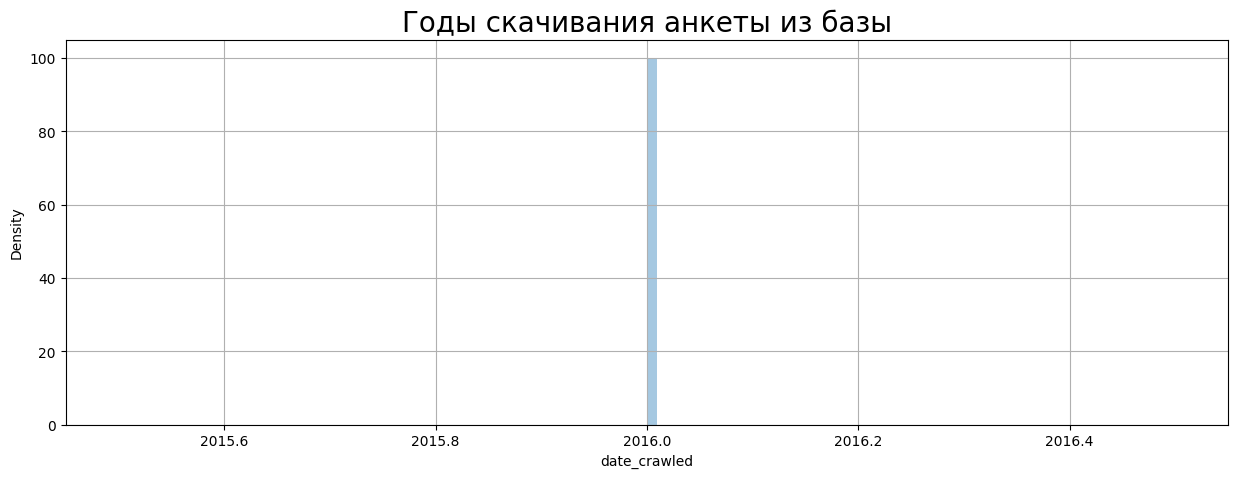

In [26]:
hist_df(df['date_crawled'].dt.year, 'Годы скачивания анкеты из базы')

Все анкеты были скачаны в 2016 году, значит в датафрейме не может быть данных по году выпуска автомобилей после этого года.  
При изучении общей информации в столбце `registration_year` замечены аномальные значения (минимум 1000, максимум 9999). Первый автомобиль был выпущен в 1885году. Оставим в датафрейме значения только с 1900 по 2016 год.

In [27]:
df = df.query('1900 <= registration_year <= 2016')

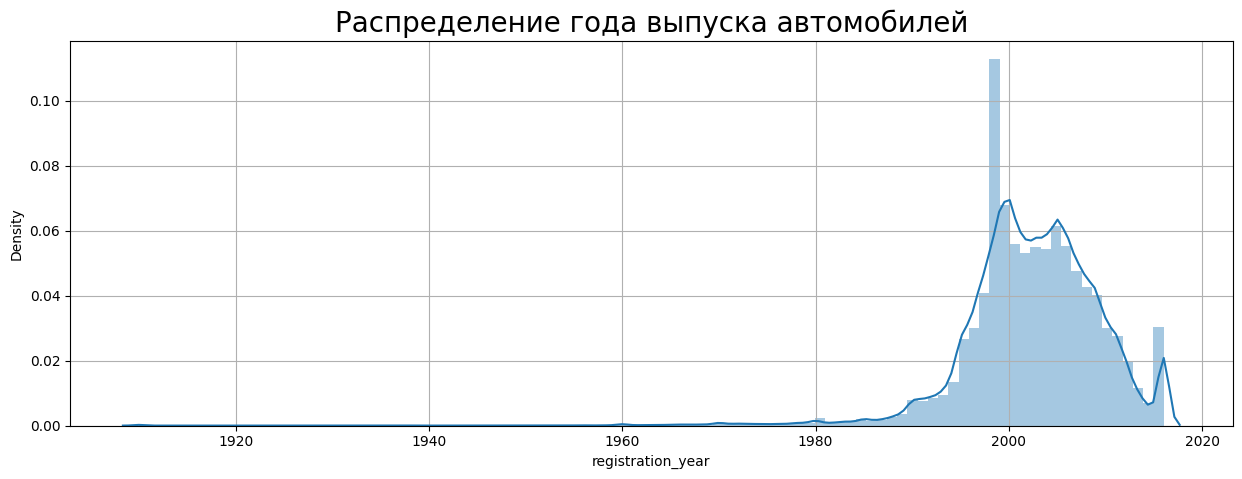

In [28]:
hist_df(df['registration_year'], 'Распределение года выпуска автомобилей')

Теперь выглядит более правдоподобно, но не единичные значения начинают появляться только после 1960 года. Отбросим все значения до указанного года

In [29]:
df = df.query('1960 <= registration_year')

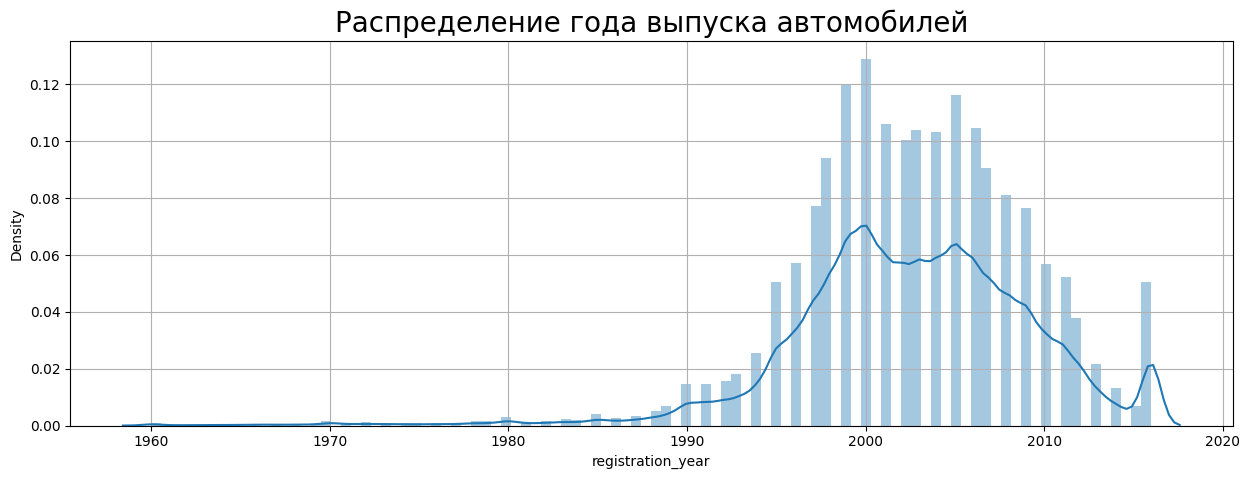

In [30]:
hist_df(df['registration_year'], 'Распределение года выпуска автомобилей')

Количество лошадиных сил в автомобилей врядли может быть меньше 20 лошадиных сил и точно не может быть более 2000 лошадиных сил (2000л.с. - мощность самого мощного легкового автомобиля в мире названного Dagger GT компании TranStar Racing LLC). Оставим в датафрейме значения только из указанного диапазона.

In [31]:
df = df.query('20 < power < 2000')

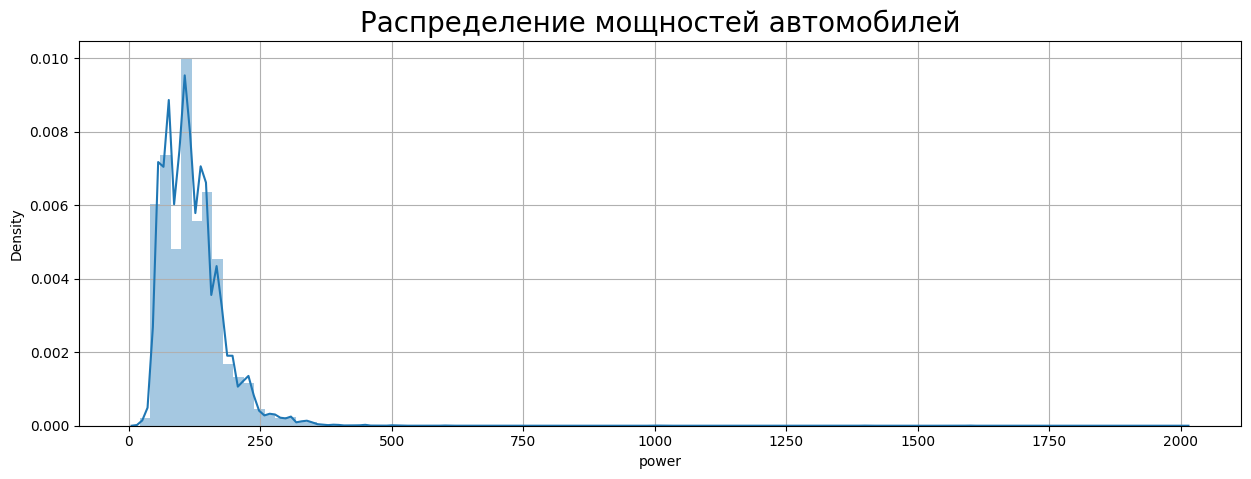

In [32]:
hist_df(df['power'], 'Распределение мощностей автомобилей')

Похоже, все значения более 400л.с. являются единичными выбросами. Отбросим их и оставим только значения до 400л.с.

In [33]:
df = df.query('20 < power < 400')

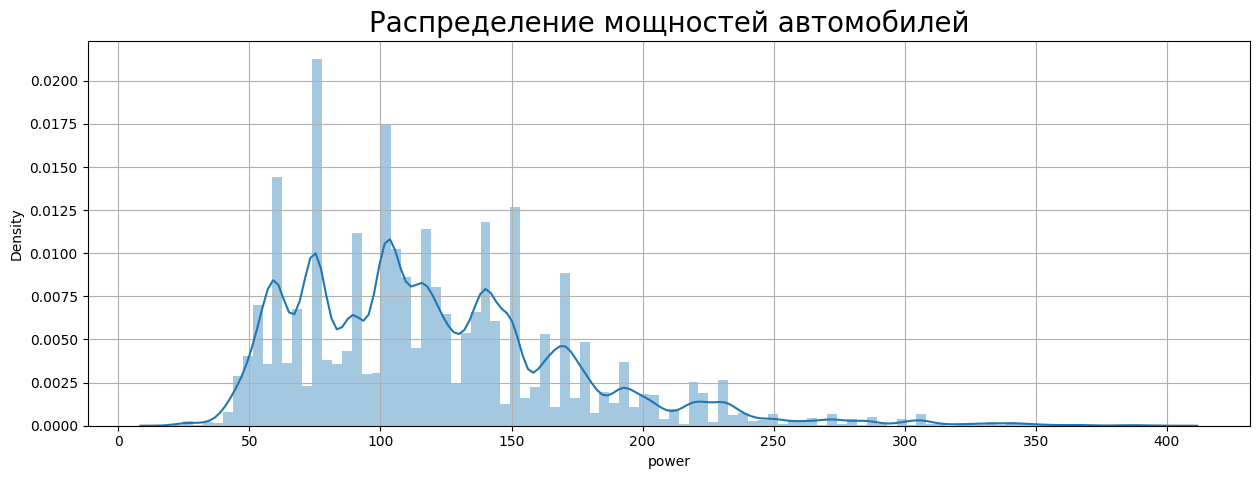

In [34]:
hist_df(df['power'], 'Распределение мощностей автомобилей')

Преобладают автомобили эконом сегмента с мощностью до 150л.с., далее с повышению мощностей количество автомобилей падает.

Выведем количество значений по каждому месяцу регистрации

In [35]:
df['registration_month'].value_counts()

3     30777
6     28023
4     26128
5     26039
7     24191
10    23298
12    21558
11    21337
9     21258
1     20509
8     20076
0     19667
2     19158
Name: registration_month, dtype: int64

Номера месяцев начинаются с 1 и заканчиваются 12 (1 - январь, 2 - февраль, и т.д.). Предположим, что значения 0 обозначают, что месяц не указан.

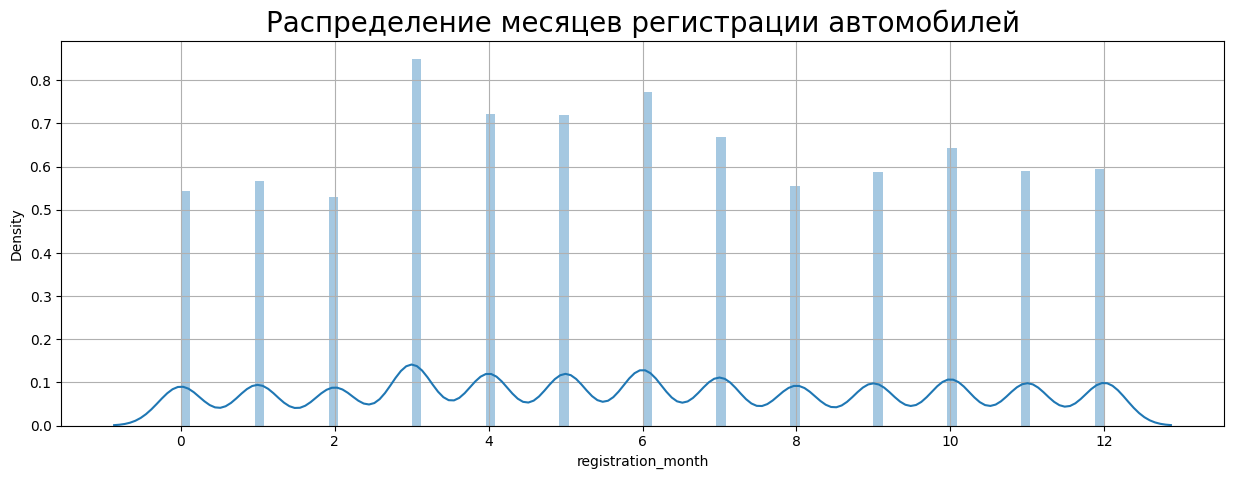

In [36]:
hist_df(df['registration_month'], 'Распределение месяцев регистрации автомобилей')

Данные по месяцу регистрации распределены более-менее равномерно.

Данные по пробегу (столбец `kilometer`) трогать не будем. Судя по общей информации представленные данные - логичные.

В целевом признаке - цена (`price`), при изучении общей информации обнаружили минимальное значение 0. Выведем строки, в которых цена на авто равнялась 0:

In [37]:
df[df['price'] == 0]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
231,2016-03-16 22:06:24,0,wagon,2001,manual,115,mondeo,150000,0,petrol,ford,unknown,2016-03-16 00:00:00,0,57627,2016-03-26 11:17:50
466,2016-03-24 10:58:40,0,sedan,2016,auto,197,3er,150000,12,gasoline,bmw,no,2016-03-24 00:00:00,0,99867,2016-03-25 19:46:09
524,2016-03-25 22:53:44,0,bus,2005,manual,136,verso,100000,10,petrol,toyota,unknown,2016-03-25 00:00:00,0,86163,2016-03-26 07:44:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354175,2016-03-20 17:55:27,0,small,1995,manual,45,polo,150000,0,petrol,volkswagen,unknown,2016-03-20 00:00:00,0,2625,2016-04-07 00:46:35
354205,2016-03-09 15:56:30,0,small,2000,manual,65,corsa,150000,0,petrol,opel,yes,2016-03-09 00:00:00,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002,manual,60,fiesta,150000,3,petrol,ford,unknown,2016-03-20 00:00:00,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999,manual,53,swift,150000,3,petrol,suzuki,unknown,2016-03-24 00:00:00,0,42329,2016-04-07 05:17:24


Более 6 тысяч значений с нулевой ценой, при этом остальные значения в порядке. Заполним данные значения медианой в зависимости от года выпуска, бренда и модели авто.

In [38]:
df.loc[df['price'] == 0, 'price'] = np.nan
df['price'] = df['price'].fillna(df.groupby(['brand', 'model', 'power', 'registration_year'])['price'].transform('median'))

Выведем оставшиеся пропущенные значения:

In [39]:
df['price'].isna().sum()

813

Данное количество значений мало, по сравнению со всем датасетом, поэтому можем отбросить их не боясь потерять в качестве.

In [40]:
df = df.query('price > 0')

Выделим столбцы, которые не несут полезной информации для обучения моделей: `DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`, `PostalCode`. Удалим их из исходного датафрейма.

In [41]:
df = df.drop(['date_crawled',
              'date_created',
              'last_seen',
              'number_of_pictures',
              'postal_code'], axis=1)

Избавимся от полных дубликатов

In [42]:
df = df.drop_duplicates().reset_index(drop=True)

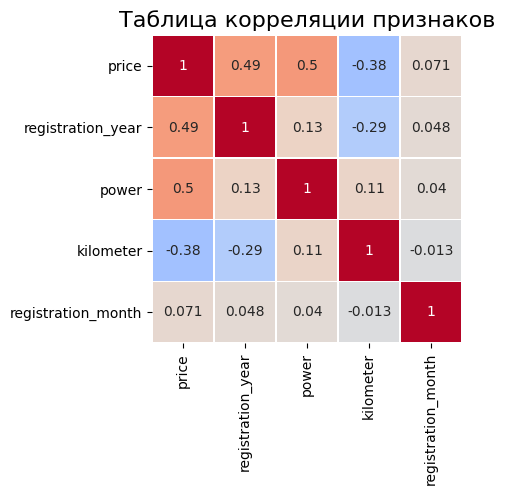

In [43]:
# построим таблицу корреляции признаков Пирсона
plt.figure(figsize=(4, 4))
plt.title('Таблица корреляции признаков', fontsize=16)
sns.heatmap(df.corr(),
        annot=True,
        vmin=-1, vmax=1, center=0,
        cbar=False, robust=True,
        cmap='coolwarm', linewidth=0.2); 

Корреляция Пирсона работает только для нормально распределённых непрерывных переменных.   
Используем другой метод - матрицу `phik` - она анализирует корреляцию между признаками любого типа и не требует предварительного кодирования. При использовании `phik` настроим параметр `interval_cols`, передав ему список с названиями непрерывных признаков (в нашем случае это признак `price`): если этого не сделать, библиотека своими силами будет пытаться разнести признаки по типам, и она часто делает в этом ошибки - от этого в свою очередь мы получаем некорректную оценку корреляций, так как от типа признака зависит метод оценки корреляции.

In [44]:
phik_overview = df.phik_matrix(interval_cols=['price', 'registration_year', 'power', 'kilometer'])
phik_overview

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
price,1.000000,0.265837,0.664828,0.319303,0.516455,0.580923,0.317930,0.131310,0.256675,0.359461,0.343548
vehicle_type,0.265837,1.000000,0.178963,0.275583,0.497179,0.915174,0.176075,0.078958,0.326485,0.634809,0.097450
registration_year,0.664828,0.178963,1.000000,0.124958,0.287312,0.636042,0.396209,0.115273,0.259850,0.376186,0.216049
gearbox,0.319303,0.275583,0.124958,1.000000,0.581652,0.651184,0.026129,0.052298,0.149594,0.529819,0.026538
power,0.516455,0.497179,0.287312,0.581652,1.000000,0.811324,0.118631,0.055529,0.258061,0.583707,0.120274
model,0.580923,0.915174,0.636042,0.651184,0.811324,1.000000,0.444922,0.152254,0.554456,0.998493,0.230682
kilometer,0.317930,0.176075,0.396209,0.026129,0.118631,0.444922,1.000000,0.068956,0.145425,0.272005,0.226610
registration_month,0.131310,0.078958,0.115273,0.052298,0.055529,0.152254,0.068956,1.000000,0.070382,0.089199,0.316770
fuel_type,0.256675,0.326485,0.259850,0.149594,0.258061,0.554456,0.145425,0.070382,1.000000,0.324511,0.070076
brand,0.359461,0.634809,0.376186,0.529819,0.583707,0.998493,0.272005,0.089199,0.324511,1.000000,0.138388


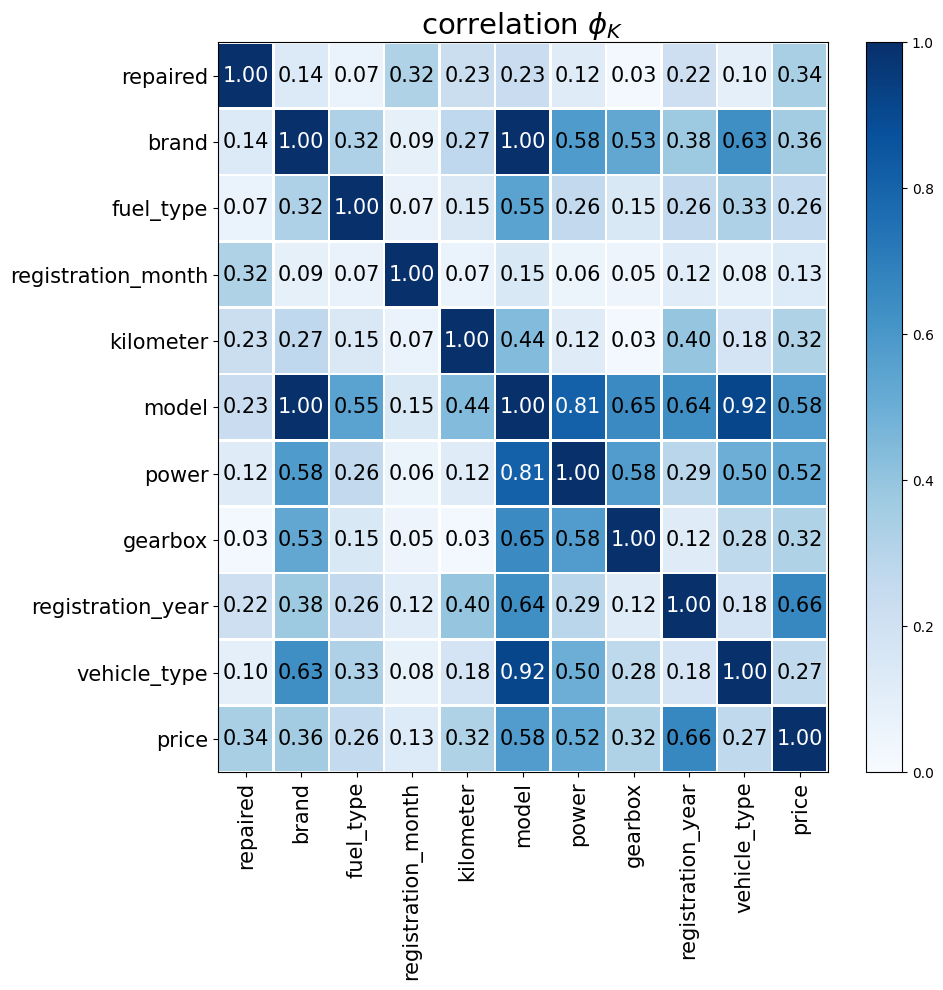

In [45]:
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(10,10))
plt.tight_layout()

Больше всего с целевым признаком (ценой) коррелируют данные по модели, году выпуска автомобиля и его мощности. Меньше всего - по месяцу регистрации.  

Также отметим, что напрямую коррелирует модель с брендом авто, мощностью и типом транспортного средства, что логично.

**Вывод:**  
В ходе изучения общей информации и предобработки данных были произведены следующие шаги:
* Данные избавлены от дубликатов;
* Устранены все пропуски;
* Удалены неинформативные для обучения моделей столбцы;
* Из данных убраны аномальные значения;
* Построена таблица корреляции признаков с целевым признаком. Наиболее коррелирующими признаками с ценой автомобиля являются модель, мощность и год выпуска авто.

## Подготовка выборок для обучения моделей

Для таких моделей как *CatBoost* и *LightGBM* не требуется кодировать данные, для них достаточно перевести нечисленные признаки в категориальные, но для линейной регрессии данные необходимо обработать. Поэтому все обучение моделей будем производить на двух выборках, данные в которых преобразуем с помощью `OneHotEncoder` и `OrdinalEncoder`, т.е. преобразуем категориальные признаки в числовые значения.

In [46]:
X = df.drop('price', axis=1)
y = df['price']

In [47]:
# Преобразуем признаки с помощью OneHotEncoder
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe)

In [48]:
X_ohe = df_ohe.drop('price', axis=1)
y_ohe = df_ohe['price']

In [49]:
def split_df(X, y):
    '''
    Разделяет признаки на обучающую, валидационную и тестовую выборки
    в размере 60:20:20, а также выводит размеры этих выборок
    '''
    # Разделим данные на обучающую, тестовую и валидационную выборки
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=RANDOM_STATE)
    X_train, X_valid, y_train, y_valid = train_test_split(X,
                                                          y,
                                                          test_size=0.2,
                                                          random_state=RANDOM_STATE)
       
    print('Размер признаков обучающей выборки:', X_train.shape)
    print('Размер целевого признака обучающей выборки:', y_train.shape)
    print('Размер признаков валидационной выборки:', X_valid.shape)
    print('Размер целевого признака валидационной выборки:', y_valid.shape)
    print('Размер признаков тестовой выборки:', X_test.shape)
    print('Размер целевого признака тестовой выборки:', y_test.shape)
        
    return (X_train, X_valid, X_test, y_train, y_valid, y_test)

In [50]:
(X_train_ohe,
 X_valid_ohe,
 X_test_ohe,
 y_train_ohe,
 y_valid_ohe,
 y_test_ohe) = split_df(X_ohe, y_ohe)

Размер признаков обучающей выборки: (220649, 314)
Размер целевого признака обучающей выборки: (220649,)
Размер признаков валидационной выборки: (55163, 314)
Размер целевого признака валидационной выборки: (55163,)
Размер признаков тестовой выборки: (55163, 314)
Размер целевого признака тестовой выборки: (55163,)


In [51]:
(X_train,
 X_valid,
 X_test,
 y_train,
 y_valid,
 y_test) = split_df(X, y)

Размер признаков обучающей выборки: (220649, 10)
Размер целевого признака обучающей выборки: (220649,)
Размер признаков валидационной выборки: (55163, 10)
Размер целевого признака валидационной выборки: (55163,)
Размер признаков тестовой выборки: (55163, 10)
Размер целевого признака тестовой выборки: (55163,)


In [52]:
# Создадим список категориальных признаков
categories = ['model',
              'registration_year',
              'vehicle_type',
              'brand',
              'gearbox',
              'registration_month',
              'fuel_type',
              'repaired']
# Преобразуем признаки с помощью OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value',
                         unknown_value=333)
# Копируем выборки
X_train_encoder = X_train.copy()
X_valid_encoder = X_valid.copy()
X_test_encoder = X_test.copy()
# Обучаем и трансформируем обучающую выборку
X_train_encoder[categories] = encoder.fit_transform(X_train_encoder[categories])
# Трансформируем валидационную и тестовую выборки
X_valid_encoder[categories] = encoder.transform(X_valid[categories])
X_test_encoder[categories] = encoder.transform(X_test[categories])

## Обучение моделей

Обучать будем несколько моделей: `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor` и `XGBRegressor`. Для каждой модели попробуем разные гиперпараметры.

Напишем функцию, которая будет обучать модели, получать предсказания и фиксировать время, затраченное на обучение и предсказания.

In [53]:
def model_fit(model, features_train, target_train, features_valid, target_valid):
    '''
    На вход получает модель обучения, признаки и целевой признак для
    обучающей и валидационной выборок.
    На выходе считает RMSE модели, время обучения и время предсказания
    '''
    # Обучаем модель
    start_fit = time.time() # фиксируем время начала обучения
    model.fit(features_train, target_train) # обучаем модель
    time_fit = time.time() - start_fit # регистрируем время обучения
    # Получаем предсказания модели
    start_predict = time.time() # фиксируем время начала предсказаний
    predicted_valid = model.predict(features_valid)
    time_predict = time.time() - start_predict # регистрируем время предсказаний
    # Считаем RMSE модели
    rmse_score = mean_squared_error(target_valid, predicted_valid, squared=False)
    
    print(model, '\n',
          'RMSE:', round(rmse_score, 2), '\n',
          'Время обучения:', round(time_fit, 2), '\n',
          'Время предсказания:', round(time_predict, 2))
    
    return (rmse_score, time_fit * 1000, time_predict * 1000)

In [54]:
scorer = 'neg_mean_squared_error'

### LinearRegression

In [55]:
# Объявим модель
model_lr = LinearRegression()

In [56]:
# Объявим параметры модели
params_lr = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'copy_X': [True, False],
    'n_jobs': [1, -1]
}

In [57]:
# Объявим параметры сетки
grid_lr = GridSearchCV(
    estimator=model_lr, 
    param_grid=params_lr, 
    cv=3, 
    scoring=scorer)

In [58]:
# Обучим модель
grid_lr.fit(X_train_ohe, y_train_ohe)

# Отобразим лучшие параметры
print("LinearRegressor лучшие параметры:", grid_lr.best_params_)

LinearRegressor лучшие параметры: {'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': False}


In [59]:
model_lr_best = LinearRegression(
    fit_intercept=True,
    normalize=False,
    copy_X=True,
    n_jobs=1
)

In [60]:
(rmse_lr,
 time_fit_lr,
 time_predict_lr) = model_fit(model_lr_best,
                              X_train_ohe,
                              y_train_ohe,
                              X_valid_ohe,
                              y_valid_ohe)

LinearRegression(n_jobs=1, normalize=False) 
 RMSE: 2610.83 
 Время обучения: 7.34 
 Время предсказания: 0.14


### RandomForestRegressor

In [61]:
# Объявим модель
model_rfr = RandomForestRegressor()

In [62]:
# Объявим параметры модели
params_rfr = {'n_estimators': [10, 30, 50],
             'max_depth': [1, 5, 10],
             'random_state': [RANDOM_STATE]}

In [63]:
# Объявим параметры сетки
grid_rfr = GridSearchCV(estimator=model_rfr,
                        param_grid=params_rfr,
                        scoring=scorer,
                        cv=3)

In [64]:
# Обучим модель OrdinalEncoder
grid_rfr.fit(X_train_encoder, y_train)

# Отобразим лучшие параметры
print("RandomForestRegressor лучшие параметры:", grid_rfr.best_params_)

RandomForestRegressor лучшие параметры: {'max_depth': 10, 'n_estimators': 50, 'random_state': 12345}


In [65]:
# Объявим модель с лучшими параметрами
model_rfr_best = RandomForestRegressor(max_depth=10,
                                       n_estimators=50,
                                       random_state=RANDOM_STATE)

In [66]:
(rmse_rfr,
 time_fit_rfr,
 time_predict_rfr) = model_fit(model_rfr_best,
                               X_train_encoder,
                               y_train,
                               X_valid_encoder,
                               y_valid)

RandomForestRegressor(max_depth=10, n_estimators=50, random_state=12345) 
 RMSE: 1853.58 
 Время обучения: 20.1 
 Время предсказания: 0.27


### CatBoostRegressor

In [67]:
# Объявим модель
model_cbr = CatBoostRegressor()

In [68]:
# Объявим параметры модели
params_cbr = {'depth': [6, 8, 10],
              'learning_rate': [0.1, 0.5],
              'metric_period': [10],
              'random_state': [RANDOM_STATE]}

In [69]:
# Объявим параметры сетки
grid_cbr = GridSearchCV(estimator=model_cbr,
                        param_grid=params_cbr,
                        scoring=scorer,
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

In [70]:
# Обучим модель OHE
grid_cbr.fit(X_train_ohe, y_train_ohe)

# Отобразим лучшие параметры
print("CatBoostRegressor_OHE лучшие параметры:", grid_cbr.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 4252.9932277	total: 201ms	remaining: 3m 21s
10:	learn: 2485.4662022	total: 717ms	remaining: 1m 4s
20:	learn: 1982.1154994	total: 1.26s	remaining: 58.7s
30:	learn: 1823.9036483	total: 1.78s	remaining: 55.6s
40:	learn: 1757.8852721	total: 2.25s	remaining: 52.8s
50:	learn: 1722.2048416	total: 2.73s	remaining: 50.7s
60:	learn: 1696.1703367	total: 3.21s	remaining: 49.4s
70:	learn: 1674.7130155	total: 3.7s	remaining: 48.4s
80:	learn: 1659.0549422	total: 4.17s	remaining: 47.3s
90:	learn: 1644.9180273	total: 4.66s	remaining: 46.5s
100:	learn: 1631.3089312	total: 5.12s	remaining: 45.6s
110:	learn: 1620.3472576	total: 5.6s	remaining: 44.9s
120:	learn: 1610.2160558	total: 6.11s	remaining: 44.4s
130:	learn: 1600.1094221	total: 6.6s	remaining: 43.8s
140:	learn: 1591.6953655	total: 7.1s	remaining: 43.3s
150:	learn: 1583.3509775	total: 7.58s	remaining: 42.6s
160:	learn: 1575.7137192	total: 8.04s	remaining: 41.9s
170:	learn: 1568.92

In [71]:
# Объявим модель с лучшими параметрами
model_cbr_ohe_best = CatBoostRegressor(depth=10,
                                       learning_rate=0.1,
                                       metric_period=10,
                                       random_state=RANDOM_STATE)

In [72]:
(rmse_cbr_ohe,
 time_fit_cbr_ohe,
 time_predict_cbr_ohe) = model_fit(model_cbr_ohe_best,
                                   X_train_ohe,
                                   y_train_ohe,
                                   X_valid_ohe,
                                   y_valid_ohe)

0:	learn: 4252.9932277	total: 48.6ms	remaining: 48.5s
10:	learn: 2485.4662022	total: 504ms	remaining: 45.3s
20:	learn: 1982.1154994	total: 981ms	remaining: 45.8s
30:	learn: 1823.9036483	total: 1.48s	remaining: 46.3s
40:	learn: 1757.8852721	total: 1.95s	remaining: 45.6s
50:	learn: 1722.2048416	total: 2.42s	remaining: 45.1s
60:	learn: 1696.1703367	total: 2.88s	remaining: 44.4s
70:	learn: 1674.7130155	total: 3.36s	remaining: 44s
80:	learn: 1659.0549422	total: 3.84s	remaining: 43.6s
90:	learn: 1644.9180273	total: 4.36s	remaining: 43.6s
100:	learn: 1631.3089312	total: 4.86s	remaining: 43.3s
110:	learn: 1620.3472576	total: 5.33s	remaining: 42.7s
120:	learn: 1610.2160558	total: 5.79s	remaining: 42s
130:	learn: 1600.1094221	total: 6.25s	remaining: 41.5s
140:	learn: 1591.6953655	total: 6.72s	remaining: 40.9s
150:	learn: 1583.3509775	total: 7.2s	remaining: 40.5s
160:	learn: 1575.7137192	total: 7.67s	remaining: 40s
170:	learn: 1568.9201120	total: 8.17s	remaining: 39.6s
180:	learn: 1561.9688496	to

In [73]:
# Обучим модель OrdinalEncoder
grid_cbr.fit(X_train_encoder, y_train)

# Отобразим лучшие параметры
print("CatBoostRegressor_Encoder лучшие параметры:", grid_cbr.best_params_)

Fitting 3 folds for each of 6 candidates, totalling 18 fits
0:	learn: 4258.6724556	total: 37.8ms	remaining: 37.7s
10:	learn: 2495.7310531	total: 448ms	remaining: 40.2s
20:	learn: 1999.7481994	total: 885ms	remaining: 41.2s
30:	learn: 1832.3719407	total: 1.31s	remaining: 40.9s
40:	learn: 1759.5811012	total: 1.77s	remaining: 41.4s
50:	learn: 1719.1794445	total: 2.2s	remaining: 41s
60:	learn: 1686.1276891	total: 2.66s	remaining: 41s
70:	learn: 1663.8454776	total: 3.14s	remaining: 41s
80:	learn: 1643.5874810	total: 3.6s	remaining: 40.9s
90:	learn: 1628.2038209	total: 4.06s	remaining: 40.6s
100:	learn: 1612.3590223	total: 4.55s	remaining: 40.5s
110:	learn: 1599.8792582	total: 5.03s	remaining: 40.3s
120:	learn: 1587.9983798	total: 5.5s	remaining: 39.9s
130:	learn: 1577.7026664	total: 6.02s	remaining: 39.9s
140:	learn: 1567.9978599	total: 6.49s	remaining: 39.5s
150:	learn: 1559.0462857	total: 6.96s	remaining: 39.2s
160:	learn: 1550.2828915	total: 7.43s	remaining: 38.7s
170:	learn: 1542.6558596

In [74]:
# Объявим модель с лучшими параметрами
model_cbr_encoder_best = CatBoostRegressor(depth=10,
                                           learning_rate=0.1,
                                           metric_period=10,
                                           random_state=RANDOM_STATE)

In [75]:
(rmse_cbr_encoder,
time_fit_cbr_encoder,
time_predict_cbr_encoder) = model_fit(model_cbr_encoder_best,
                                      X_train_encoder,
                                      y_train,
                                      X_valid_encoder,
                                      y_valid)

0:	learn: 4258.6724556	total: 39.9ms	remaining: 39.8s
10:	learn: 2495.7310531	total: 473ms	remaining: 42.5s
20:	learn: 1999.7481994	total: 905ms	remaining: 42.2s
30:	learn: 1832.3719407	total: 1.34s	remaining: 41.8s
40:	learn: 1759.5811012	total: 1.78s	remaining: 41.6s
50:	learn: 1719.1794445	total: 2.23s	remaining: 41.5s
60:	learn: 1686.1276891	total: 2.7s	remaining: 41.6s
70:	learn: 1663.8454776	total: 3.22s	remaining: 42.1s
80:	learn: 1643.5874810	total: 3.68s	remaining: 41.8s
90:	learn: 1628.2038209	total: 4.15s	remaining: 41.4s
100:	learn: 1612.3590223	total: 4.61s	remaining: 41s
110:	learn: 1599.8792582	total: 5.05s	remaining: 40.4s
120:	learn: 1587.9983798	total: 5.58s	remaining: 40.5s
130:	learn: 1577.7026664	total: 6.1s	remaining: 40.5s
140:	learn: 1567.9978599	total: 6.54s	remaining: 39.9s
150:	learn: 1559.0462857	total: 7.05s	remaining: 39.7s
160:	learn: 1550.2828915	total: 7.57s	remaining: 39.5s
170:	learn: 1542.6558596	total: 8.05s	remaining: 39s
180:	learn: 1534.7517929	t

### LGBMRegressor

In [76]:
# Объявим модель
model_lgbm = LGBMRegressor()

In [77]:
# Объявим параметры модели
params_lgbm = {'num_leaves':[60],
               'learning_rate':[0.1,0.5],
               'max_depth':[6,10],
               'random_state':[RANDOM_STATE]}

In [78]:
# Объявим параметры сетки
grid_lgbm = GridSearchCV(estimator=model_lgbm,
                         param_grid=params_lgbm,
                         scoring=scorer,
                         cv=3,
                         n_jobs=-1)

In [79]:
# Обучим модель OHE
grid_lgbm.fit(X_train_ohe, y_train_ohe)

# Отобразим лучшие параметры
print("LGBMRegressor_OHE лучшие параметры:", grid_lgbm.best_params_)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 220649, number of used features: 296
[LightGBM] [Info] Start training from score 4780.929247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBMRegressor_OHE лучшие параметры: {'learning_rate': 0.5, 'max_depth': 10, 'num_leaves': 60, 'random_state': 12345}


In [80]:
# Объявим модель с лучшими параметрами
model_lgbm_ohe_best = LGBMRegressor(learning_rate=0.5,
                                    max_depth=10,
                                    num_leaves=60,
                                    random_state=RANDOM_STATE)

In [81]:
(rmse_lgbm_ohe,
 time_fit_lgbm_ohe,
 time_predict_lgbm_ohe) = model_fit(model_lgbm_ohe_best,
                                    X_train_ohe,
                                    y_train_ohe,
                                    X_valid_ohe,
                                    y_valid_ohe)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011333 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 882
[LightGBM] [Info] Number of data points in the train set: 220649, number of used features: 296
[LightGBM] [Info] Start training from score 4780.929247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LGBMRegressor(learning_rate=0.5, max_depth=10, num_leaves=60,
              random_state=12345) 
 RMSE: 1585.02 
 Время обучения: 2.33 
 Время предсказания: 0.35


In [82]:
# Обучим модель OrdinalEncoder
grid_lgbm.fit(X_train_encoder, y_train)

# Отобразим лучшие параметры
print("LGBMRegressor_Encoder лучшие параметры:", grid_lgbm.best_params_)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013855 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 220649, number of used features: 10
[LightGBM] [Info] Start training from score 4780.929247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [83]:
# Объявим модель с лучшими параметрами
model_lgbm_encoder_best = LGBMRegressor(learning_rate=0.5,
                                        max_depth=6,
                                        num_leaves=60,
                                        random_state=RANDOM_STATE)

In [84]:
(rmse_lgbm_encoder,
 time_fit_lgbm_encoder,
 time_predict_lgbm_encoder) = model_fit(model_lgbm_encoder_best,
                                        X_train_encoder,
                                        y_train,
                                        X_valid_encoder,
                                        y_valid)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 605
[LightGBM] [Info] Number of data points in the train set: 220649, number of used features: 10
[LightGBM] [Info] Start training from score 4780.929247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

### XGBRegressor

In [85]:
# Объявим модель
model_xgb = XGBRegressor()

In [86]:
# Объявим параметры модели
params_xgb = {'learning_rate':[0.1,0.5],
              'max_depth':[6,12],
              'subsample':[0.5],
              'colsample_bytree':[0.5],
              'random_state':[RANDOM_STATE]}

In [87]:
# Объявим параметры сетки
grid_xgb = GridSearchCV(estimator=model_xgb,
                        param_grid=params_xgb,
                        scoring=scorer,
                        cv=3,
                        n_jobs=-1,
                        verbose=1)

In [88]:
# Обучим модель OHE
grid_xgb.fit(X_train_ohe, y_train_ohe)

# Отобразим лучшие параметры
print("XGBRegressor_OHE лучшие параметры:", grid_xgb.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBRegressor_OHE лучшие параметры: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 12345, 'subsample': 0.5}


In [89]:
# Объявим модель с лучшими параметрами
model_xgb_ohe_best = XGBRegressor(colsample_bytre=0.5,
                                  learning_rate=0.1,
                                  max_depth=12,
                                  random_state=RANDOM_STATE,
                                  subsample=0.5)

In [90]:
(rmse_xgb_ohe,
 time_fit_xgb_ohe,
 time_predict_xgb_ohe) = model_fit(model_xgb_ohe_best,
                                   X_train_ohe,
                                   y_train_ohe,
                                   X_valid_ohe,
                                   y_valid_ohe)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytre=0.5,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...) 
 RMSE: 1557.17 
 Время обучения: 15.75 
 Время предсказания: 0.31


In [91]:
# Обучим модель OrdinalEncoder
grid_xgb.fit(X_train_encoder, y_train)

# Отобразим лучшие параметры
print("XGBRegressor_Encoder лучшие параметры:", grid_xgb.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
XGBRegressor_Encoder лучшие параметры: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 12, 'random_state': 12345, 'subsample': 0.5}


In [92]:
# Объявим модель с лучшими параметрами
model_xgb_encoder_best = XGBRegressor(colsample_bytre=0.5,
                                      learning_rate=0.1,
                                      max_depth=12,
                                      random_state=RANDOM_STATE,
                                      subsample=0.5)

In [93]:
(rmse_xgb_encoder,
 time_fit_xgb_encoder,
 time_predict_xgb_encoder) = model_fit(model_xgb_encoder_best,
                                       X_train_encoder,
                                       y_train,
                                       X_valid_encoder,
                                       y_valid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytre=0.5,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...) 
 RMSE: 1560.56 
 Время обучения: 4.84 
 Время предсказания: 0.17


## Анализ работы моделей

Сведем все полученные результаты по каждой модели в одну таблицу:

In [94]:
result_final_dict = {'RMSE': [rmse_lr, rmse_rfr,
                             rmse_cbr_ohe, rmse_cbr_encoder,
                             rmse_lgbm_ohe, rmse_lgbm_encoder,
                             rmse_xgb_ohe, rmse_xgb_encoder],
                    'Время обучения': [time_fit_lr, time_fit_rfr,
                                      time_fit_cbr_ohe, time_fit_cbr_encoder,
                                      time_fit_lgbm_ohe, time_fit_lgbm_encoder,
                                      time_fit_xgb_ohe, time_fit_xgb_encoder],
                    'Время предсказания': [time_predict_lr, time_predict_rfr,
                                          time_predict_cbr_ohe, time_predict_cbr_encoder,
                                          time_predict_lgbm_ohe, time_predict_lgbm_encoder,
                                          time_predict_xgb_ohe, time_predict_xgb_encoder]}
result_final = pd.DataFrame(result_final_dict, index=['LinearRegression', 'RandomForestRegressor_Encoder',
                                                     'CatBoostRegressor_OHE', 'CatBoostRegressor_Encoder',
                                                     'LGBMRegressor_OHE', 'LGBMRegressor_Encoder',
                                                     'XGBRegressor_OHE', 'XGBRegressor_Encoder'])
result_final.round(2)

,RMSE,Время обучения,Время предсказания
LinearRegression,2610.83,7340.98,140.62
RandomForestRegressor_Encoder,1853.58,20095.29,265.27
CatBoostRegressor_OHE,1536.63,50635.53,291.22
CatBoostRegressor_Encoder,1539.95,46492.39,226.28
LGBMRegressor_OHE,1585.02,2326.88,351.50
LGBMRegressor_Encoder,1621.99,991.66,166.56
XGBRegressor_OHE,1557.17,15748.05,307.73
XGBRegressor_Encoder,1560.56,4841.41,169.55


Наилучший результат по среднеквадратичной ошибке *RMSE* показала модель `CatBoostRegressor` с данными, закодированными при помощи `OneHotEncoder`.  

Самая быстрая модель по времени предсказывания `XGBRegressor_Encoder`, времени обучения - `LGBMRegressor_Encoder`. Наихудший показатель *RMSE* у модели линейной регрессии.  

Критерию Заказчика по значению *RMSE* не превышающую 2500 удовлетворяют все модели, кроме модели линейной регрессии.   

По совокупности характеристик, наилучшая модель - `LGBMRegressor` с данными, закодированными при помощи `OrdinalEncoder`. У данной модели высокая скорость обучения и предсказания, а *RMSE* немногим выше *RMSE* `CatBoostRegressor`.

Протестируем лучшую модель на тестовой выборке:

In [95]:
# Получаем предсказания модели
start_predict = time.time() # фиксируем время начала предсказаний
predicted_test = model_lgbm_encoder_best.predict(X_test_encoder)
time_predict = time.time() - start_predict # регистрируем время предсказаний
# Считаем RMSE модели
rmse_score = mean_squared_error(y_test, predicted_test, squared=False)
    
print('RMSE:', round(rmse_score, 2), '\n',
      'Время предсказания:', round(time_predict, 2))

RMSE: 1621.99 
 Время предсказания: 0.2


## Общий вывод

В ходе работы над проектом проведены следующие шаги:
* Изучена общая информация об исходных данных, проведена предобработка данных (устранение дубликатов и пропусков, удаление неиформативных признаков, устранение аномальных значений);
* На основе предобработанных данных произведено разделение выборок для обучения моделей в соотношении 60% (обучающая выборка), 20% (валидационная выборка) и 20% (тестовая выборка). Данные кодировали при помощи двух методов: `OneHotEncoder` и `OrdinalEncoder`.
* Обучили и сравнили показатели пяти моделей: `LinearRegression`, `RandomForestRegressor`, `CatBoostRegressor`, `LGBMRegressor` и `XGBRegressor`.
* Выбрали наилучшую модель по совокупности характеристик (*RMSE*, время обучения и время предсказания) - `LGBMRegressor` с данными, закодированными при помощи `OrdinalEncoder`. Данная модель имееть показала значение метрики *RMSE* на тестовой выборке равным 1621.99, что удовлетворяет требованию Заказчика.